# Embeddings

## Sommaire
* [Qu'est ce qu'un embedding ?](#qu-est-ce-qu-un-embedding)
* [Mesure de la similarité](#mesure-de-la-similarite)
* [Word2Vec](#word2vec)
  * [Modèle: skipgram](#modele-skipgram)
  * [Modèle: sac de mots continus](#modele-sac-de-mots-continus)
  * [Mise en pratique](#id1)
* [Glove: Global Vectors](#glove-global-vectors)
  * [Co-occurence de mots](#co-occurence-de-mots)
  * [Association avec des vecteurs](#association-avec-des-vecteurs)
  * [Mise en pratique](#mise-en-pratique)
* [Exploration de topics: t-Distributed Stochastic Neighbor Embedding (t-SNE)](#exploration-de-topics-t-distributed-stochastic-neighbor-embedding-t-sne)
  * [Paranthèse sur le Gaussian](#paranthese-sur-le-gaussian)
  * [Divergence de Kullback-Leibler](#divergence-de-kullback-leibler)
  * [Mise en pratique](#id2)

## Qu'est ce qu'un embedding ?

Un embedding est une représentation mathématique d'un objet ou d'un concept sous la forme d'un vecteur le permettant ainsi d'être évalué par un programme informatique, et plus particulièrement un réseau de neurones.

Pour illustrer ce qu'est un embedding nous prendrons pour exemple: une voiture, une moto et un être humain:

* Une voiture possède 4 roues et est un véhicule, nous lui attribuons donc le vecteur: [1, 1, 1, 1, 1]
* Une moto possède 2 roues et est un véhicule, nous lui attribuons le vecteur: [1, 0, 0, 1, 1]
* Enfin un humain ne possède pas de roue et n'est pas un véhicule, donc: [0, 0, 0, 0, 0]

<p align="center"> <b>Exemple d'embedding simpliste</b>
<img src="https://user-images.githubusercontent.com/65224852/186540909-8b3257a5-4e3c-499d-a556-1f4308e43196.png">
</p>

C'est une manière de représenter les données cependant il en existe d'autres comme le sac de mots, par rapport aux phrases, que l'on a étudié dans le chapitre sur la modélisation statistique du langage.

Ainsi la machine peut comparer les données et les interpréter, pour comparer deux embeddings nous utilisons une mesure de similarité.

Il faut cependant avoir à l'esprit que les meilleurs algorithmes d'embedding ne fournissent pas des caractéristiques bien précises à analyser tel que le nombre de roues ou le sexe d'une personne, au lieu de cela c'est une combinaison de facteurs qui est utilisé et leur étude permet notamment de combattre les biais en machine learning dans le cadre du NLP.

## Mesure de la similarité

La mesure de similarité la plus courante pour comparer deux vecteurs est la similarité cosinus (ou cosine similarity).

Pour obtenir la similarité cosinus on part d'un produit vectoriel:

$$\begin{align} &A \cdot B = \left\| A \right\| \left\| B \right\| cos(\theta)
\\ \implies &cos(\theta) = \frac{A \cdot B}{\left\| A \right\| \left\| B \right\|}
\\ \implies &cos(\theta) = \frac{\sum_{i=1}^nA_iB_i}{\sqrt{\sum_{i=1}^nA_i^2}\sqrt{\sum_{i=1}^nB_i^2}}
\end{align}$$

Suivant la valeur de $cos(\theta)$ on étudie la similarité des vecteurs A et B:
* Lorsque $cos(\theta)$ tend vers 1 les deux vecteurs sont colinéaires de facteur positif, en d'autres termes similaires.
* Lorsque $cos(\theta)$ tend vers 0 les deux vecteurs sont orthogonaux, soit non similaire
* Lorsque $cos(\theta)$ tend vers -1 les deux vecteurs sont colinéaires de facteur négatif, soit opposés.

Maintenant utilisons cette mesure de similarité sur notre exemple précédent pour étudier la proximité des vecteurs:

**Comparaison Voiture et Moto:**
* $V \cdot M = 1*1 + 1*0 + 1*0 + 1*1 + 1*1 = 3$
* $\left\| V \right\| \left\| M \right\| = \sqrt{1^2 + 1^2 + 1^2 + 1^2 + 1^2} \sqrt{1^2 + 0^2 + 0^2 + 1^2 + 1^2} = \sqrt{5} \sqrt{3} = \sqrt{15}$

$\implies cos(\theta) = \frac{V \cdot M}{\left\| V \right\| \left\| M \right\|} = \frac{3}{\sqrt{15}} \simeq 0,7746$
  
**Comparaison Voiture et Humain:**
* $V \cdot M = 1*0 + 1*0 + 1*0 + 1*0 + 1*0 = 0$

$\implies cos(\theta) = 0$
  
Sans surprise la moto a plus de similarité avec la voiture que l'humain.

## Word2Vec

<p align="center"> <i>Pour cette partie il est fortement recommandé d'avoir étudié les réseaux de neurones et les calculs sous-jacents tel que la backpropagation.

Source de cette partie: https://arxiv.org/pdf/1411.2738.pdf.</i></p>

Word2Vec est une famille d'algorithmes ayant pour but de fournir des embeddings de grande qualité, nous étudierons ici deux algorithmes: le modèle skipgram et le modèle sac de mots continus (ou continuous bag of words).

### Modèle: skipgram

L'algorithme skipgram de Word2Vec prend en entrée un mot et à partir de ce mot reconstitue un contexte composé de T mots (T étant la taille du contexte visé), pour cela le modèle utilise un réseau de neurone feed-forward à une seule couche avec un **Hierarchical Softmax** afin d'obtenir une représentation vectorielle optimisée *(aussi nommé embedding)* du mot $w_n$.

<p align="center"> <b>Architecture Word2Vec: skipgram</b>
<img src="https://user-images.githubusercontent.com/65224852/186547778-0844025a-9ebe-49c1-a43f-7539dc2228bf.png">
</p>

L'objectif de l'entraînement est d'optimiser cette fonction:

$$\begin{align}E &= -log \, p(w_{n-T}, \cdots, w_{n+T}|w_n)
\\ &= -log\prod_{t=-T}^T p(w_{n+t}|w_n)\end{align}$$

Où:
* $w_n$: Mot d'indice n.
* $M$: Cardinal de l'ensemble des mots.

Le softmax habituel est trop coûteux à calculer en raison du trop grand nombre de mots, la formule serait la suivante:

$$p(w_{n+t}|w_n) = \frac{v'_{w_{n+t}} \,^\top v_{w_n}}{\sum_{i=1}^M \exp(v'_{w_i} \,^\top v_{w_n})}$$

Où:
* $t$: Contexte de taille T (*voir comme un intervalle*) pour un mot en position n.
* $v_{w_n}$: vecteur pris en entrée du mot d'indice n.
* $v'_{w_n}$: vecteur de sortie du mot d'indice n.

#### Hierarchical Softmax:

Le Hierarchical Softmax est une méthode plus efficace pour calculer le softmax grâce à sa complexité $O(log(M))$ tandis que le softmax a une complexité $O(M)$.

Pour cela on considère le réseau de neurones comme un **arbre binaire de Huffman** *(possède strictement deux enfants par noeud)* où chaque feuille représente un mot du vocabulaire, il existe un unique chemin de la racine au mot et ce chemin est utilisé pour calculer la probabilité des mots.

<p align="center"> <b>Hierarchical Softmax: Arbre binaire de Huffman</b>
<img src="https://user-images.githubusercontent.com/65224852/186721250-a73309b6-1ec8-4910-a557-29c6429ad4b3.png" width=600 height=300>
</p>

Où:
* $n(w, j)$: j-éme noeud du chemin au mot $w$.
* $L(w)$: Longueur du chemin au mot $w$.

Dans ce modèle il n'y a pas de vecteur de sortie au niveau des feuilles mais chaque noeud correspond à un vecteur, *(il y en a en tout $M-1$)*, le but est d'optimiser le vecteur de la racine qui correspond au mot $w_n$.

La probabilité d'obtenir un mot est la suivante:

$$p(w | w_n) = \prod_{j=1}^{L(w_n)-1} \sigma([n(w,j+1) = ch(n(w,j))] \cdot v'_{n(w,j)} \,^\top v_{w_n})$$

Où:
* $ch(n)$: est l'enfant de gauche du noeud n.
* $v'_{n(w,j)}$: représentation vectorielle du noeud j.
* $[n(w,j+1) = ch(n(w,j))]$: vaut 1 si vrai sinon -1.
* $\sigma(x) = \frac{1}{1+e^{-x}}$: fonction d'activation sigmoid.

Pour comprendre cette formule nous utiliserons un exemple où l'on calcule la probabilité d'obtenir $w_2$ d'après le schéma précédent, il faut voir le calcul de cette probabilité comme une marche aléatoire de noeud en noeud.

Pour chaque noeud *(incluant la racine)* nous définissons la probabilité d'aller à droite ou à gauche pour un noeud $j$ de la manière suivante:

$$\begin{equation} \begin{cases} p(j, left) = \sigma(v'_j \cdot \,^\top v_{w_n})
\\ p(j, right) = 1 - \sigma(v'_j \cdot \,^\top v_{w_n}) = \sigma(-v'_j \cdot \,^\top v_{w_n}) \end{cases} \end{equation}$$

Ainsi la probabilité d'obtenir $w_2$ est:

$$\begin{align} p(w_2 | w_n) &= p(n(w_2, 1), left) \cdot p(n(w_2, 2), left) \cdot p(n(w_2, 3), right)
\\ &= \sigma(v'_{n(w_2, 1)} \,^\top v_{w_n}) \cdot \sigma(v'_{n(w_2, 2)} \,^\top v_{w_n}) \cdot \sigma(v'_{n(w_2, 3)} \,^\top v_{w_n}) \end{align}$$

Et cette marche aléatoire défini une distribution multinomiale parmis tous les mots du vocabulaire.

### Modèle: sac de mots continus

Ce modèle a un fonctionnement opposé au modèle skipgram, il prend en entrée un contexte de $T$ mots et donne la probabilité d'obtenir un mot spécifique pour ce contexte, pour cela le modèle utilise un réseau de neurone feed-forward à une seule couche afin d'obtenir une représentation vectorielle optimisée des mots du contexte $(w_{n-T}, \cdots, w_{n+T})$.

<p align="center"> <b>Architecture Word2Vec: sac de mots continus</b>
<img src="https://user-images.githubusercontent.com/65224852/186798004-27c63a1a-c868-4088-bc92-1c091db86dbb.png">
</p>

L'objectif de l'entraînement est d'optimiser cette fonction:

$$\begin{align}E &= -log \, p(w_n | w_{n-T}, \cdots, w_{n+T})
\\ &=-v'_{w_n} \cdot \,^\top h + log \sum_{j=1}^M exp(v'_{w_j} \cdot \,^\top h)\end{align}$$

Où:
* $v'_{w_n}$: représentation vectorielle de sortie du mot n.
* $h$: moyenne des vecteurs pris en entrée:

$$h = \frac{1}{T}(v_{w_{n-T}} + v_{w_{n-T+1}} + \cdots + v_{w_{n+T}})$$

### Mise en pratique:

Dans cette partie nous essayerons de comparer les représentations vectorielles de différents mots à l'aide de Word2Vec et de la similarité cosinus.

Pour cela nous utiliserons la librairie Gensim et ntlk, pour installer les requirements tapez:

```
pip install nltk
pip install gensim
pip install unidecode
```

Le dataset utilisé est un petit corpus de textes présent dans la page github, il n'est pas suffisament grand pour avoir de bonnes corrélations mais une petite idée.

In [95]:
import re
import nltk
import gensim
import warnings
import unidecode
from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize
 
def text_processing(text):
    ''' Return cleaned text for Machine Learning '''
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    NEW_LINE = re.compile('\n')
    BAD_SYMBOLS_RE = re.compile('[^a-z\' #+_]')

    text = text.lower()
    text = unidecode.unidecode(text)
    text = NEW_LINE.sub(' ',text)
    text = REPLACE_BY_SPACE_RE.sub('',text)
    text = BAD_SYMBOLS_RE.sub(' ',text)
    return text
    
#nltk.download('punkt')
warnings.filterwarnings(action = 'ignore')
    
total_text = ""
data = []

#  Reads files
train_files = ['data/corpus_1.txt', 'data/corpus_2.txt', 'data/corpus_3.txt', 'data/corpus_4.txt']

for file_path in train_files:
    with open(file_path,'r', encoding="utf-8") as file:
        for line in file:
            tmp = line
            tmp = tmp.replace("\n", " ")
            total_text = total_text + tmp
                
for s in sent_tokenize(total_text):
    temp = []

    # tokenize the sentence into data
    content = text_processing(s)
    token = content.split()
    data.append(token)
    
# Create CBOW model
model1 = gensim.models.Word2Vec(data, min_count = 1, vector_size = 100, window = 5)
 
# Print results
print("=== Modèle CBOW ===")
print("Similarité cosinus entre 'jour' " + "et 'stylo' - CBOW : ", model1.wv.similarity('jour', 'stylo'))
print("Top 10 mots corrélés à 'jour' - CBOW : ", model1.wv.most_similar('jour', topn=5))
 
# Create Skip Gram model
model2 = gensim.models.Word2Vec(data, min_count = 1, vector_size = 100, window = 5, sg = 1)
 
# Print results
print("\n=== Modèle Skip Gram ===")
print("Similarité cosinus entre 'jour' " + "et 'stylo' - Skip Gram : ", model2.wv.similarity('jour', 'stylo'))
print("Top 10 mots corrélés à 'jour' - Skip Gram : ", model2.wv.most_similar('jour', topn=5))

=== Modèle CBOW ===
Similarité cosinus entre 'jour' et 'stylo' - CBOW :  0.85024124
Top 10 mots corrélés à 'jour' - CBOW :  [('encore', 0.9996173977851868), ('alors', 0.9996070861816406), ('fut', 0.9996036291122437), ("qu'on", 0.9995915293693542), ('oui', 0.9995855689048767)]

=== Modèle Skip Gram ===
Similarité cosinus entre 'jour' et 'stylo' - Skip Gram :  0.8073238
Top 10 mots corrélés à 'jour' - Skip Gram :  [('lendemain', 0.9945391416549683), ('lire', 0.9927944540977478), ('ecrit', 0.9927003383636475), ('point', 0.9919275045394897), ('francais', 0.9918561577796936)]


Dans cette situation skip gram a de meilleures performances que CBOW.

Skip-gram fonctionne bien avec de petites quantités de données d'entraînement, et représente bien les mots rares ou les phrases.

Tandis que CBOW est beaucoup plus rapide à entraîner que le modèle skip-gram, et possède une précision légérement meilleure pour les mots fréquents.

## GloVe: Global Vectors

<p align="center"> <i>Source de cette partie: <a href="https://aclanthology.org/D14-1162.pdf">https://aclanthology.org/D14-1162.pdf</a></i></p>

A l'instar de Word2Vec, GloVe vise à fournir des embeddings de grande qualité à partir de la distribution de probabilité des mots dans un corpus donné.

GloVe signifie *Global Vectors* puisque dans ce modèle les statistiques globales du corpus sont capturées directement par le modèle.

La question est de savoir comment à partir de ces statistiques on peut obtenir du sens pour les mots sous forme de vecteur.

### Co-occurence de mots:

Tout débute avec les probabilités de co-occurence de mots, notons:

* $X$: matrice de co-occurence de mots.
* $X_{i,j}$: nombre de fois qu'un mot $j$ apparaît dans le contexte d'un mot $i$.
* $X_i = \sum_k^M X_{i,k}$ le nombre de fois qu'un mot quelconque $k$ apparaît dans le contexte du mot $i$.
* $P_{i,j} = P(j|i) = \frac{X_{i,j}}{X_i}$ la probabilité qu'un mot $j$ apparaît dans contexte d'un mot $i$.

D'après ces notations et une série d'exemples basées sur des phases en thermodynamique *(glace, vapeur, solide...)* on observe le tableau suivant:

<p align="center"> <b>Tableau de probabilités de co-occurence</b>
<img src="https://user-images.githubusercontent.com/65224852/188535001-079ccb85-4bc7-463c-895b-4910e979c217.png">
</p>

Comme on pourrait s'y attendre: le mot **glace** apparaît plus fréquemment avec le mot **solide** que le mot **gas**, tandis que le mot **vapeur** apparaît plus fréquemment avec le mot **gas** qu'avec le mot **solide**, les deux mots apparaissent à part égale avec le mot **eau** et enfin le mot **fashion** n'apparaît presque jamais.

Le ratio de probabilités de co-occurence est capable de distinguer des mots corrélés par rapport à des mots non corrélés.

Ainsi un bon point de départ pour l'apprentissage de représentations vectorielles de mots devrait être le ratio des probabilités de co-occurence plutôt que les probabilités elle-même.

### Association avec des vecteurs:

Soit le modèle général:

$$F(w_i, w_j, \tilde{w}_k) = \frac{P_{i,k}}{P_{j,k}}$$

Où:
* $w_i$: vecteur du mot $i$.
* $\tilde{w}_i$: vecteur d'un mot $i$ d'un contexte séparé.

On souhaite encoder l'information présent dans le ratio $\frac{P_{i,k}}{P_{j,k}}$ et puisque les espaces vectoriels sont des structures linéaires la manière la plus naturelle de le faire est de prendre la différence des vecteurs:

$$F(w_i - w_j, \tilde{w}_k) = \frac{P_{i,k}}{P_{j,k}}$$

Puis on pose:

$$F((w_i - w_j) \,^\top \tilde{w}_k) = \frac{P_{i,k}}{P_{j,k}}$$

La distinction entre un mot et un mot du contexte est arbitraire, nous sommes libre d'échanger les deux rôles. Ainsi $w \leftrightarrow \tilde{w}$ et $X \leftrightarrow X \,^\top$, le modèle doit donc être invariant à cette modification mais ce n'est pas le cas avec la formule précédente.

On résout le problème en posant:

$$\begin{align} F((w_i - w_j) \,^\top \tilde{w}_k) &= \frac{F(w_i \,^\top \tilde{w}_k)}{F(w_j \,^\top \tilde{w}_k)} = \frac{P_{i,k}}{P_{j,k}}
\\ \implies F(w_i \,^\top \tilde{w}_k) &= P_{i,k} = \frac{X_{i,k}}{X_i} \end{align}
\\ \implies F = exp \quad \text{ et } \quad w_i \,^\top \tilde{w}_k = log(P_{i,k}) = log(X_{i,k}) - log(X_i)$$

Enfin pour que cette équation possède une symétrie par l'échange des contextes il faudrait modifier $log(X_i)$, ce terme est indépendant de $k$ donc il peut être absorbé dans un biais $b_i$ pour $w_i$, puis nous ajoutons un biais $\tilde{b}_k$ pour $\tilde{w}_k$, restorant la symétrie.

$$\begin{align} \implies w_i \,^\top \tilde{w}_k + log(X_i) &= log(X_{i,k})
\\ \implies w_i \,^\top \tilde{w}_k + b_i + \tilde{b}_k &= log(X_{i,k}) \end{align}$$

C'est une simplification drastique de la toute première équation *(le modèle général)* et mal définie puisque le logarithme diverge en 0.

C'est pourquoi GloVe utilise un modèle de régression des moindres carrés pondérés, remplaçant l'équation précédente en un problème des moindres carrés pondéré par une fonction $f$ tel que:

$$J = \sum_{i,j=1}^V f(X_{i,j}) \, (w_i \,^\top \tilde{w}_k + b_i + \tilde{b}_j - log(X_{i,j}))^2$$

Où:
* $V$: taille du vocabulaire.

La fonction $f$ doit obéir à certaines régles tel que:
* $f(0) = 0$ rendant $lim_{x \rightarrow 0} \, f(x) \, log^2(x)$ fini.
* $f(x)$ ne doit pas être décroissante.
* $f(x)$ doit être relativement petite pour de grandes valeurs de x.

Un grand nombre de fonctions satisfont ces propriétés mais une classe de fonctions fonctionne plutôt bien et est paramétrisée de la sorte:

$$\begin{equation} f(x) = \begin{cases} (x/x_{\text{max}})^\alpha \quad &\text{si } x < x_{\text{max}}
\\ 1 \quad &\text{sinon} \end{cases} \end{equation}$$

De manière empirique les paramétres retenus sont $\alpha = 3/4$ et $x_{\text{max}} = 100$.

### Mise en pratique:

Pour cette mise en pratique nous recoderons entièrement l'algorithme étant donné que les packages en ligne ne fonctionnent pas.

Habituellement on télécharge un fichier texte contenant les vecteurs d'une version pré-entraînée de GloVe.

*Aucune version n'est disponible sur pip et cloner le repertoire de l'université de Stanford: https://github.com/stanfordnlp/GloVe ne permet pas d'être compilé sous Windows à cause de <pthread.h>.*

Pour mener à bien notre implémentation de GloVe il faudra installer:

```
pip install gensim
pip install torch
pip install dataclasses
pip install h5py
pip install tqdm
pip install numpy
```

In [20]:
#=== Etape 0- Données d'entraînement ===#

import gensim.downloader as api
import itertools

dataset = api.load("text8")
corpus = list(itertools.chain.from_iterable(dataset))
corpus = corpus[0:100000]

#Nous entraînerons l'algorithme sur les 100000 premier mots
#étant donné que le temps d'apprentissage peut être très long !"""

In [21]:
import os

#=== Paramétres ===#

vocab_size = 10000 #100000 normalement
window_size = 10
num_partitions = 10
chunk_size = 1000000
cooccurrence_dir = os.getcwd()
output_filepath = os.getcwd()+"glove.pth"
batch_size = 32
num_epochs = 20
device = "cpu"
learning_rate = 0.05
embedding_size = 100
x_max = 100
alpha = 0.75

In [22]:
import random

#=== Etape 1- Compter les paires co-occurente ===#

"""Il faut déterminer le vocabulaire, c'est un ensemble de tokens associés
à un entier, si un token n'appartient pas au corpus il est représenté par 'unk'.
Nous n'utiliserons qu'un subset de tokens: le top k des tokens les plus fréquents"""

from dataclasses import dataclass, field

@dataclass
class Vocabulary:
    token2index: dict = field(default_factory=dict) #Dictionnaire qui associe un token à un entier.
    index2token: dict = field(default_factory=dict) #Dictionnaire qui associe un entier à un token.
    token_counts: list = field(default_factory=list) #Liste où la i-éme valeur est le nombe de token avec l'index i.
    _unk_token: int = field(init=False, default=-1) #Entier pour les tokens inconnus.
    
    def add(self, token):
        #Ajoute un token au vocabulaire.
        if token not in self.token2index:
            index = len(self)
            self.token2index[token] = index
            self.index2token[index] = token
            self.token_counts.append(0)
        self.token_counts[self.token2index[token]] += 1
    
    def get_topk_subset(self, k):
        #Créer un vocabulaire avec le top k des tokens.
        tokens = sorted(
            list(self.token2index.keys()),
            key=lambda token: self.token_counts[self[token]],
            reverse=True
        )
        return type(self)(
            token2index={token: index for index, token in enumerate(tokens[:k])},
            index2token={index: token for index, token in enumerate(tokens[:k])},
            token_counts=[
                self.token_counts[self.token2index[token]] for token in tokens[:k]
            ]
        )
    
    def shuffle(self):
        #Mélange aléatoirement les tokens et indices.
        new_index = [_ for _ in range(len(self))]
        random.shuffle(new_index)
        new_token_counts = [None] * len(self)
        for token, index in zip(list(self.token2index.keys()), new_index):
            new_token_counts[index] = self.token_counts[self[token]]
            self.token2index[token] = index
            self.index2token[index] = token
        self.token_counts = new_token_counts

    def get_index(self, token):
        return self[token]
    
    def get_token(self, index):
        if not index in self.index2token:
            raise Exception("Invalid index.")
        return self.index2token[index]
    
    @property
    def unk_token(self):
        return self._unk_token
    
    def __getitem__(self, token):
        if token not in self.token2index:
            return self._unk_token
        return self.token2index[token]
    
    def __len__(self):
        return len(self.token2index)
    
@dataclass
class Vectorizer:
    vocab: Vocabulary

    @classmethod
    def from_corpus(cls, corpus, vocab_size):
        
        """Créer un vocabulaire en ajoutant tous les tokens dans le corpus,
        puis le top vocab_size est selectionné pour créer un nouveau vocabulaire,
        ensuite on mélange."""
        
        vocab = Vocabulary()
        for token in corpus:
            vocab.add(token)
        vocab_subset = vocab.get_topk_subset(vocab_size)
        vocab_subset.shuffle()
        return cls(vocab_subset)

    def vectorize(self, corpus):
        return [self.vocab[token] for token in corpus]

In [23]:
#=== Etape 1B- Scan des fenêtres de contexte ===#

"""Scanner l'ensemble des données pour établir le nombre possible de paires
co-occurente pourrait surcharger la RAM, c'est pourquoi on découpe en plusieurs
scans, de plus pour préserver le compte entre chaque scan on utilisera une
librairie h5py pour sauvegarder de grosse quantités de données."""

from collections import Counter
from tqdm import tqdm
import numpy as np
import pickle
import torch
import h5py

@dataclass
class CooccurrenceEntries:
    vectorized_corpus: list
    vectorizer: Vectorizer
    
    @classmethod
    def setup(cls, corpus, vectorizer):
        return cls(
            vectorized_corpus=vectorizer.vectorize(corpus),
            vectorizer=vectorizer
        )
    
    def validate_index(self, index, lower, upper):
        is_unk = index == self.vectorizer.vocab.unk_token
        if lower < 0:
            return not is_unk
        return not is_unk and index >= lower and index <= upper

    def build(
        self,
        window_size,
        num_partitions,
        chunk_size,
        output_directory="."
    ):
        partition_step = len(self.vectorizer.vocab) // num_partitions
        split_points = [0]
        while split_points[-1] + partition_step <= len(self.vectorizer.vocab):
            split_points.append(split_points[-1] + partition_step)
        split_points[-1] = len(self.vectorizer.vocab)

        for partition_id in tqdm(range(len(split_points) - 1)):
            index_lower = split_points[partition_id]
            index_upper = split_points[partition_id + 1] - 1
            cooccurr_counts = Counter()
            for i in tqdm(range(len(self.vectorized_corpus))):
                if not self.validate_index(
                    self.vectorized_corpus[i],
                    index_lower,
                    index_upper
                ):
                    continue
                
                context_lower = max(i - window_size, 0)
                context_upper = min(i + window_size + 1, len(self.vectorized_corpus))
                for j in range(context_lower, context_upper):
                    if i == j or not self.validate_index(
                        self.vectorized_corpus[j],
                        -1,
                        -1
                    ):
                        continue
                    cooccurr_counts[(self.vectorized_corpus[i], self.vectorized_corpus[j])] += 1 / abs(i - j)

            cooccurr_dataset = np.zeros((len(cooccurr_counts), 3))
            for index, ((i, j), cooccurr_count) in enumerate(cooccurr_counts.items()):
                cooccurr_dataset[index] = (i, j, cooccurr_count)
            if partition_id == 0:
                file = h5py.File(
                    os.path.join(
                        output_directory,
                        "cooccurrence.hdf5"
                    ),
                    "w"
                )
                dataset = file.create_dataset(
                    "cooccurrence",
                    (len(cooccurr_counts), 3),
                    maxshape=(None, 3),
                    chunks=(chunk_size, 3)
                )
                prev_len = 0
            else:
                prev_len = dataset.len()
                dataset.resize(dataset.len() + len(cooccurr_counts), axis=0)
            dataset[prev_len: dataset.len()] = cooccurr_dataset
        
        file.close()
        with open(os.path.join(output_directory, "vocab.pkl"), "wb") as file:
            pickle.dump(self.vectorizer.vocab, file)
            
@dataclass
class CooccurrenceDataset(torch.utils.data.Dataset):
    token_ids: torch.Tensor
    cooccurr_counts: torch.Tensor

    def __getitem__(self, index):
        return [self.token_ids[index], self.cooccurr_counts[index]]
    
    def __len__(self):
        return self.token_ids.size()[0]

In [ ]:
#=== Etape 1C- Utilisation du code pour compter les paires ===#

vectorizer = Vectorizer.from_corpus(
    corpus=corpus,
    vocab_size=vocab_size)

cooccurrence = CooccurrenceEntries.setup(
    corpus=corpus,
    vectorizer=vectorizer)

cooccurrence.build(
    window_size=window_size,
    num_partitions=num_partitions,
    chunk_size=chunk_size,
    output_directory=cooccurrence_dir)

In [25]:
#=== Etape 2- Création du modèle ===#

import torch
import contextlib
import torch.nn as nn

@dataclass
class HDF5DataLoader:
    filepath: str
    dataset_name: str
    batch_size: int
    device: str
    dataset: h5py.Dataset = field(init=False)

    def iter_batches(self):
        chunks = list(self.dataset.iter_chunks())
        random.shuffle(chunks)
        for chunk in chunks:
            chunked_dataset = self.dataset[chunk]
            dataloader = torch.utils.data.DataLoader(
                dataset=CooccurrenceDataset(
                    token_ids=torch.from_numpy(chunked_dataset[:,:2]).long(),
                    cooccurr_counts=torch.from_numpy(chunked_dataset[:,
                        2]).float()
                ),
                batch_size=self.batch_size,
                shuffle=True,
                pin_memory=True
            )
            for batch in dataloader:
                batch = [_.to(self.device) for _ in batch]
                yield batch

    @contextlib.contextmanager
    def open(self):
        with h5py.File(self.filepath, "r") as file:
            self.dataset = file[self.dataset_name]
            yield
            
class GloVe(nn.Module):

    def __init__(self, vocab_size, embedding_size, x_max, alpha):
        super().__init__()
        self.weight = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_size,
            sparse=True
        )
        self.weight_tilde = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_size,
            sparse=True
        )
        self.bias = nn.Parameter(
            torch.randn(
                vocab_size,
                dtype=torch.float,
            )
        )
        self.bias_tilde = nn.Parameter(
            torch.randn(
                vocab_size,
                dtype=torch.float,
            )
        )
        self.weighting_func = lambda x: (x / x_max).float_power(alpha).clamp(0, 1)
    
    def forward(self, i, j, x):
        loss = torch.mul(self.weight(i), self.weight_tilde(j)).sum(dim=1)
        loss = (loss + self.bias[i] + self.bias_tilde[j] - x.log()).square()
        loss = torch.mul(self.weighting_func(x), loss).mean()
        return loss

In [ ]:
#=== Etape 2B- Entraînement du modèle ===#

dataloader = HDF5DataLoader(
    filepath=os.path.join(cooccurrence_dir, "cooccurrence.hdf5"),
    dataset_name="cooccurrence",
    batch_size=batch_size,
    device=device
)
model = GloVe(
    vocab_size=vocab_size,
    embedding_size=embedding_size,
    x_max=x_max,
    alpha=alpha
)
model.to(device)
optimizer = torch.optim.Adagrad(
    model.parameters(),
    lr=learning_rate
)
with dataloader.open():
    model.train()
    losses = []
    for epoch in tqdm(range(num_epochs)):
        epoch_loss = 0
        for batch in tqdm(dataloader.iter_batches()):
            loss = model(
                batch[0][:, 0],
                batch[0][:, 1],
                batch[1]
            )
            epoch_loss += loss.detach().item()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        losses.append(epoch_loss)
        print(f"Epoch {epoch+1}: loss = {epoch_loss}")
        torch.save(model.state_dict(), output_filepath)

In [27]:
from gensim.models.keyedvectors import KeyedVectors

with open(os.path.join(cooccurrence_dir, "vocab.pkl"), "rb") as f:
    vocab = pickle.load(f)

keyed_vectors = KeyedVectors(vector_size=embedding_size)
keyed_vectors.add_vectors(
    keys=[vocab.get_token(index) for index in range(vocab_size)],
    weights=(model.weight.weight.detach() + model.weight_tilde.weight.detach()).numpy())
    
print("Similarité entre woman et man:")
print(keyed_vectors.similarity("woman", "man"))
for word in ["computer", "united", "early"]:
    print(f"Mots les plus similaires de {word}:")
    most_similar_words = [word for word, _ in keyed_vectors.similar_by_word(word)]
    print(most_similar_words)

Similarité entre woman et man:
0.028059274
Mots les plus similaires de computer:
['work', 'willers', 'exercising', 'fundamental', 'emphasizing', 'contradictions', 'stabbed', 'voyages', 'basic', 'beard']
Mots les plus similaires de united:
['chronologically', 'essentiallly', 'sinking', 'auguste', 'contested', 'lyman', 'conceal', 'nebraska', 'disprove', 'armoured']
Mots les plus similaires de early:
['confidence', 'produce', 'elected', 'theoretic', 'harmonious', 'gellius', 'ayers', 'climatology', 'analogy', 'templeton']


Les résultats semblent étrange mais la raison est que je n'ai utilisé qu'un tout petit dataset, en effet la taille du dataset est d'une importance capitale pour entraîner des modèles en NLP.

Voici les résultats d'un autre utilisateur sur l'ensemble du dataset *(plus d'une journée d'entraînement)*:

<p align="center">
<img src="https://user-images.githubusercontent.com/65224852/188748546-000f1293-26a7-42a7-834f-6722aadc8587.png">
</p>

## Exploration de topics: t-Distributed Stochastic Neighbor Embedding (t-SNE)

<p align="center"> <i>Source de cette partie: <a href="https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf">https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf</a></i></p>

t-SNE est un algorithme d'apprentissage non supervisé permettant d'analyser des données décrites dans des espaces à forte dimensionnalité pour les représenter dans des espaces à deux ou trois dimensions, cet algorithme facilite la visualisation de données.

Plus précisément cet algorithme trouve des patterns dans les données basé sur la similarité des représentations vectorielles (embeddings): les données proches dans l'espace original ont une probabilité élevée d'avoir une représentation proche dans le nouvel espace, dans le cadre du NLP on appelle ces regroupements des **topics**.

t-SNE calcule donc une mesure de similarité entre des paires d'instances (ici mots) dans un espace à forte dimensionnalité et à la fois dans un espace à faible dimensionnalité, qu'il essaie ensuite d'optimiser à l'aide d'une fonction de coût.

L'objectif est de déterminer la probabilité que des points *(voir les vecteurs comme des points)* dans un espace donné choisissent d'autres points comme voisin afin d'obtenir la distribution de probabilités des voisins dans les deux espaces et de les rendres aussi similaire que possible en minimisant leur **Divergence de Kullback-Leibler** (KLD).

Soit:
* $x_i$: vecteur représentatif d'un mot i dans l'espace à forte dimensionalité.
* $y_i$: vecteur représentatif d'un mot i dans l'espace à faible dimensionalité.
* $p_{j|i}$: probabilité d'obtenir un voisin j par rapport à i dans l'espace à forte dimensionalité.
* $q_{j|i}$:probabilité d'obtenir un voisin j par rapport à i dans l'espace à faible dimensionalité.

On pose:

$$\begin{align} p_{j|i} &= \frac{exp(-\|x_i - x_j\|^2 \, / \, 2\sigma_i^2)}{\sum_{k \not= i} exp(-\|x_i - x_j\|^2 \, / \, 2\sigma_i^2)} \qquad p_{i|i} = 0
\\ q_{j|i} &= \frac{exp(-\|y_i - y_j\|^2)}{\sum_{k \not= i} exp(-\|y_i - y_j\|^2)} \qquad q_{i|i} = 0 \end{align}$$

Où:
* $\sigma_i$: variance du Gaussian centrée sur le point $x_i$, on la trouve en effectuant une recherche binaire.

### Paranthèse sur le Gaussian:

Le Gaussian *(dont la représentation est la courbe de Gauss)* est une fonction de la forme $f(x) = exp(-x^2)$ auquel on ajoute des extensions paramétriques:

$$f(x) = \alpha \, exp\left(-\frac{(x - \beta)^2}{2c^2}\right)$$

Avec:
* $\alpha$ et $\beta$: constantes réelles non nulles.
* $\alpha$: hauteur du sommet de la courbe.
* $\beta$: position du centre du sommet de la courbe.
* $c$: déviation stantard, largeur de la courbe.

Le Gaussian est souvent utilisé pour représenter la densité de probabilités de variables aléatoires normalement distribuées, dans ce cas la fonction sera de la forme:

$$y(x) = \frac{1}{\sigma \sqrt{2 \pi}} \, exp\left(-\frac{1}{2} \left(\frac{x-m}{\sigma}\right)^2\right)$$

Avec:
* $m = \beta$
* $\sigma^2 = c^2$

<p align="center"> <b>Représentation du Gaussian</b>
<img src="https://user-images.githubusercontent.com/65224852/188928348-ee388eaa-9fbf-4043-b952-d04b9f415369.jpg">
</p>

### Divergence de Kullback-Leibler:

Si l'ensemble des points $y_i$ et $y_j$ modélisent correctement la similarité entre les données de haute dimension $x_i$ et $x_j$, les probabilités conditionnelles $p_{j|i}$ et $q_{j|i}$ seront égales.

Une manière de mesurer l'écart entre le modèle $q_{j|i}$ et $p_{j|i}$ est d'utiliser la divergence de Kullback-Leibler *(qui dans ce cas est égal à la cross-entropy plus une constante additive)*.

t-SNE minimise la divergences de Kullback-Leibler sur tous les points en utilisant une descente de gradiant, la fonction de coût C est la suivante:

$$C = KL(P | Q) = \sum_i \sum_j p_{i|j} log \frac{p_{i|j}}{q_{i|j}}$$

Où:
* $P$: distribution de probabilités jointes de l'ensemble des points $x$.
* $Q$: distribution de probabilités jointes de l'ensemble des points $y$.

Il reste encore des points à élucider mais vous avez l'idée générale de comment fonctionne l'algorithme t-SNE.

### Mise en pratique:

Dans cette mise en pratique nous visualiserons la représentation de mots sous forme de points en 2 dimensions, pour cela nous utiliserons une version pré-entraînée de GloVe et en particulier la liste des vecteurs que cette version a calculée.

De plus Scikit-learn a la gentillesse de nous fournir une fonction t-SNE, c'est pourquoi nous l'utiliserons, pour installer les dépendences tapez:

```
pip install sklearn
pip install seaborn
pip install pandas
pip install keras
pip install scipy
```

In [18]:
from keras.preprocessing.text import Tokenizer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from scipy import spatial
import seaborn as sns
import pandas as pd
import numpy as np

embeddings_index = {}

f = open('glove.6B.300d.txt', encoding='utf-8') #Peut être téléchargé sur: https://nlp.stanford.edu/data/glove.6B.zip
for line in f:
    values = line.split()
    word = value = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

def find_similar_word(emmbedes):
    nearest = sorted(embeddings_index.keys(), key=lambda word: spatial.distance.euclidean(embeddings_index[word], emmbedes))
    return nearest

print("Top 10 des mots similaires à 'livre':")
print(find_similar_word(embeddings_index['book'])[1:11])

print("\nDistance euclidienne entre le mot 'livre' et 'nouvelle':", spatial.distance.euclidean(embeddings_index['book'], embeddings_index['novel']))
print("Distance euclidienne entre le mot 'livre' et 'pomme':",spatial.distance.euclidean(embeddings_index['book'], embeddings_index['apple']))

Top 10 des mots similaires à 'livre':
['books', 'author', 'published', 'novel', 'wrote', 'memoir', 'describes', 'biography', 'illustrated', 'autobiography']

Distance euclidienne entre le mot 'livre' et 'nouvelle': 4.99204683303833
Distance euclidienne entre le mot 'livre' et 'pomme': 8.160760879516602


Puisque la distance entre un livre et une nouvelle est proche alors on devine que l'algorithme t-SNE les représentera relativement proche dans l'espace à faible dimension.

Par contre le livre et la pomme étant deux notions totalement différentes, ils devraient être représenté comme éloignés.

Maintenant prenons une sélection de 10 mots et observons leur répartition.

(10, 300)


C:\Users\Seren\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Seren\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


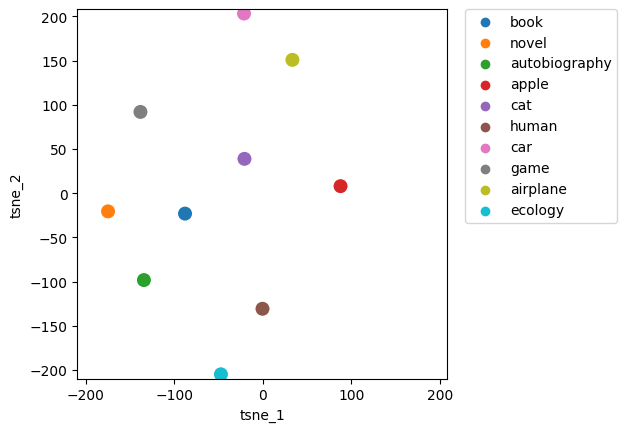

In [21]:
n_components = 2 #dimension du résultat

Y = ['book', 'novel', 'autobiography', 'apple', 'cat', 'human', 'car', 'game', 'airplane', 'ecology']
X = []
for word in Y:
    X.append(embeddings_index[word])
X = np.array(X)
print(X.shape)

tsne = TSNE(n_components, perplexity=6)
tsne_result = tsne.fit_transform(X)
tsne_result.shape

tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': Y})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=120)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

Cette répartion semble bonne pour plusieurs raisons:
* On observe que les mots "livre", "nouvelle" et "autobiographie" sont rassemblés en bas à gauche ce qui est logique puisqu'ils sont corrélés.
* On observe aussi que les mots "voiture" et "avion" sont proche dans le coin supérieur.
* Enfin les mots "écologie" et "voiture" ou "avion" sont opposés, en effet la voiture et l'avion polluent.